In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library Import

In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import leastsq #for the fit
from scipy.optimize import curve_fit

# Input Reading

In [3]:
dirName = '../../data_from_scp/'

name = 'odd_run17.odd_df2_4fop'

datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'notebook_plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    offset_diag3 = nnoise    *   nnoise   *  tvals                  * noperators        * 2         * 8
    offset_diag2 = nnoise * tvals                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        start_reading = start_conf+4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))
                            
                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)


                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            #re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                            re,im = struct.unpack("dd",fileContent[start_reading+offset_diag3:start_reading+offset_diag3+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #update start reading
                            start_reading = start_reading+16

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            #update start reading for the disconnected part
            start_reading = start_reading + offset_diag3
            
            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading+offset_diag2:start_reading+offset_diag2+16])
                    z_corr[ic][t][inoise] = complex(re,im)

                    #update start reading
                    start_reading = start_reading+16
            #update start reading for the 2point with source in z
            start_reading = start_reading + offset_diag2

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152140
Reading: Gauge Conf = 2

2319504
Reading: Gauge Conf = 3

3486868
Reading: Gauge Conf = 4

4654232
Reading: Gauge Conf = 5

5821596
Reading: Gauge Conf = 6

6988960
Reading: Gauge Conf = 7

8156324
Reading: Gauge Conf = 8

9323688
Reading: Gauge Conf = 9

10491052
Reading: Gauge Conf = 10

11658416
Reading: Gauge Conf = 11

12825780
Reading: Gauge Conf = 12

13993144
Reading: Gauge Conf = 13

15160508
Reading: Gauge Conf = 14

16327872
Reading: Gauge Conf = 15

17495236
Reading: Gauge Conf = 16

18662600
Reading: Gauge Conf = 17

19829964
Reading: Gauge Conf = 18

20997328
Reading: Gauge Conf = 19

22164692
Reading: Gauge Conf = 20

23332056
Reading: Gauge Conf = 21

24499420
Reading: Gauge Conf = 22

25666784
Reading: Gauge Conf = 23

26834148
Reading: Gauge Conf = 24

28001512
Reading: Gauge Conf = 25

29168876
Reading: Gauge Conf = 26

30336240
Reading: Gauge Conf = 27

31503604
Reading: Gauge Conf = 28

32670968
Reading: Gauge Conf = 29

33838332
Re

In [7]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [8]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(991, 1, 32, 15)
(991, 1, 32, 15)


# Jackknife with astropy

## Average over noise

In [9]:
all_2point_x_navg = all_2point_x.mean(axis=-1)
all_2point_z_navg = all_2point_z.mean(axis=-1)

if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(all_2point_x_navg))
    print(np.shape(all_2point_z_navg))

(nconf, ncorrelators, tvals)
(991, 1, 32)
(991, 1, 32)


## Estimate of mean

In [10]:
#computation of jacknife mean and related std
test_statistic = np.mean

mean_array_x = np.empty(shape=(ncorr,tvals),dtype=float)
bias_array_x = np.empty(shape=(ncorr,tvals),dtype=float)
std_array_x = np.empty(shape=(ncorr,tvals),dtype=float)
conf_interval_array_x = np.empty(shape=(ncorr,tvals,2),dtype=float)

mean_array_z = np.empty(shape=(ncorr,tvals),dtype=float)
bias_array_z = np.empty(shape=(ncorr,tvals),dtype=float)
std_array_z = np.empty(shape=(ncorr,tvals),dtype=float)
conf_interval_array_z = np.empty(shape=(ncorr,tvals,2),dtype=float)

for icorr in range(ncorr):
    for t in range(tvals):
            
        data = all_2point_x_navg[:,icorr,t].real
            
        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
        mean_array_x[icorr,t] = estimate
        bias_array_x[icorr,t] = bias
        std_array_x[icorr,t] = stderr
        conf_interval_array_x[icorr,t] = conf_interval

        data = all_2point_z_navg[:,icorr,t].real
            
        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
        mean_array_z[icorr,t] = estimate
        bias_array_z[icorr,t] = bias
        std_array_z[icorr,t] = stderr
        conf_interval_array_z[icorr,t] = conf_interval

In [19]:
std_array_x/np.abs(mean_array_x)

np.mean( (std_array_x/np.abs(mean_array_x))[0,1:-1] ) 

std_array_z/np.abs(mean_array_x)

np.mean( (std_array_z/np.abs(mean_array_z))[0,1:-1] ) 

/tmp/ipykernel_30356/3603502279.py:1: RuntimeWarning: invalid value encountered in divide
  std_array_x/np.abs(mean_array_x)


array([[       nan, 0.00012079, 0.00047524, 0.00116239, 0.00210471,
        0.00304386, 0.00390475, 0.00449726, 0.00490096, 0.00526773,
        0.00568966, 0.00609341, 0.00657471, 0.00703957, 0.0074701 ,
        0.00794516, 0.00843472, 0.00884951, 0.00931757, 0.00981537,
        0.01030927, 0.01084207, 0.01134695, 0.01197931, 0.01262674,
        0.01324131, 0.01366089, 0.01385417, 0.01386385, 0.01404825,
        0.01417074,        nan]])

/tmp/ipykernel_30356/3603502279.py:3: RuntimeWarning: invalid value encountered in divide
  np.mean( (std_array_x/np.abs(mean_array_x))[0,1:-1] )


0.008088368116877258

/tmp/ipykernel_30356/3603502279.py:5: RuntimeWarning: invalid value encountered in divide
  std_array_z/np.abs(mean_array_x)


array([[           nan, 3.23811202e-08, 4.29503467e-07, 1.81743872e-06,
        5.03519441e-06, 1.08505508e-05, 2.03891246e-05, 3.63595888e-05,
        6.36125848e-05, 1.09311947e-04, 1.85471319e-04, 3.19159177e-04,
        5.51679523e-04, 9.61902247e-04, 1.67360176e-03, 2.98397250e-03,
        5.31755422e-03, 9.41549686e-03, 1.66089162e-02, 2.93916250e-02,
        5.12880546e-02, 8.93699256e-02, 1.53984071e-01, 2.59992181e-01,
        4.29078249e-01, 7.08761717e-01, 1.22277755e+00, 2.23455378e+00,
        4.27133845e+00, 9.04341681e+00, 3.52789890e+01,            nan]])

/tmp/ipykernel_30356/3603502279.py:7: RuntimeWarning: invalid value encountered in divide
  np.mean( (std_array_z/np.abs(mean_array_z))[0,1:-1] )


0.019647677845923348

## Plots

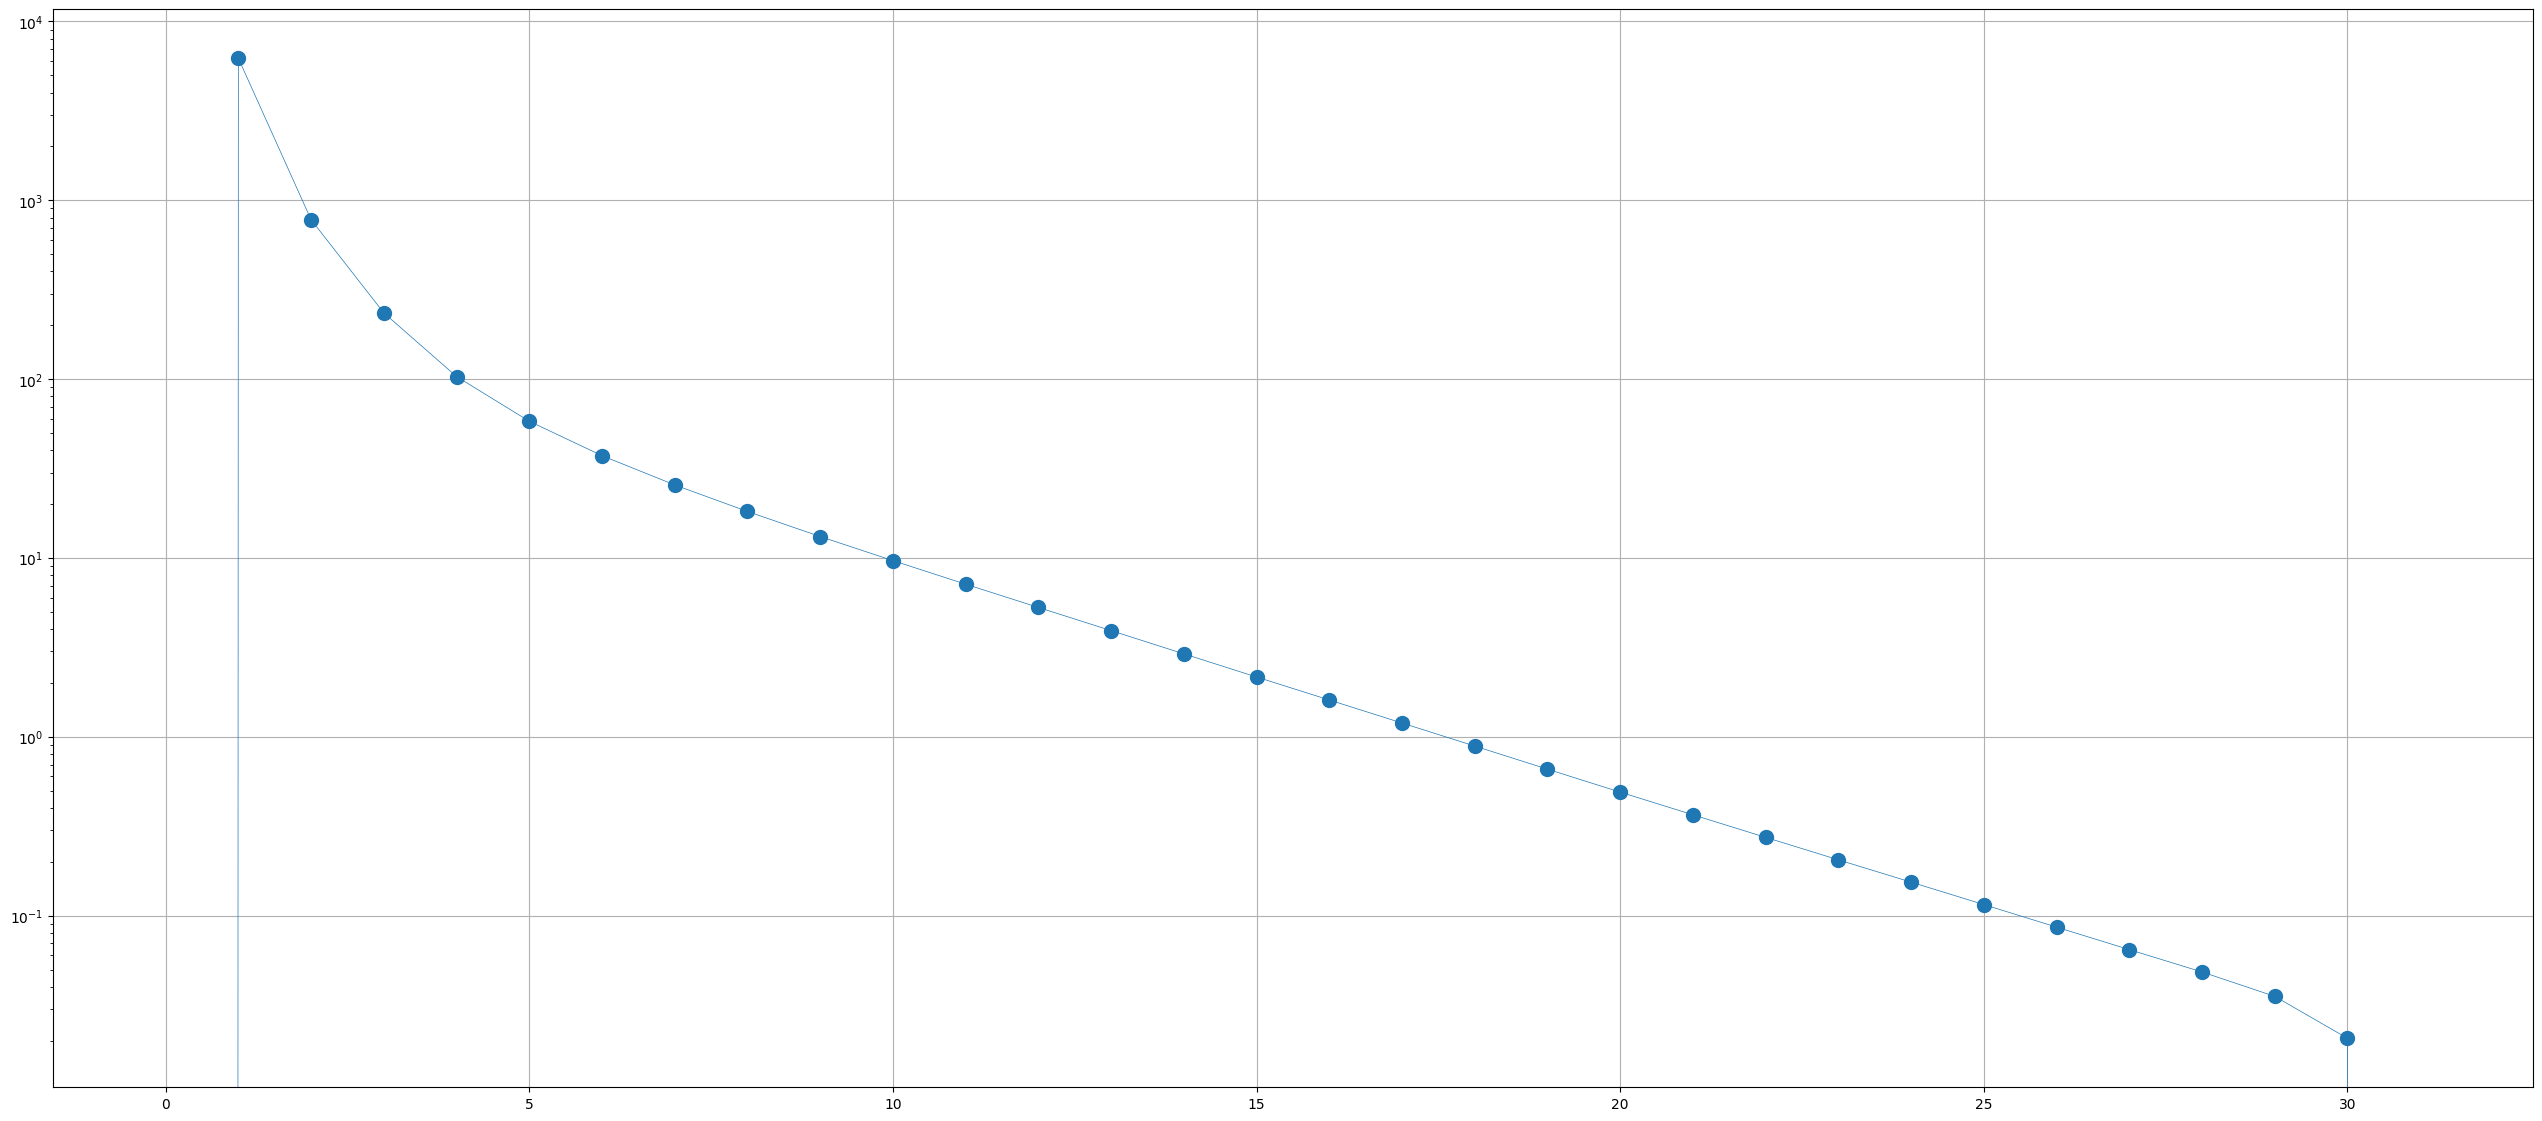

In [12]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(times,np.abs(mean_array_x[0,:]),yerr=std_array_x[0,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
_ = ax.set_yscale('log')
_ = ax.grid()

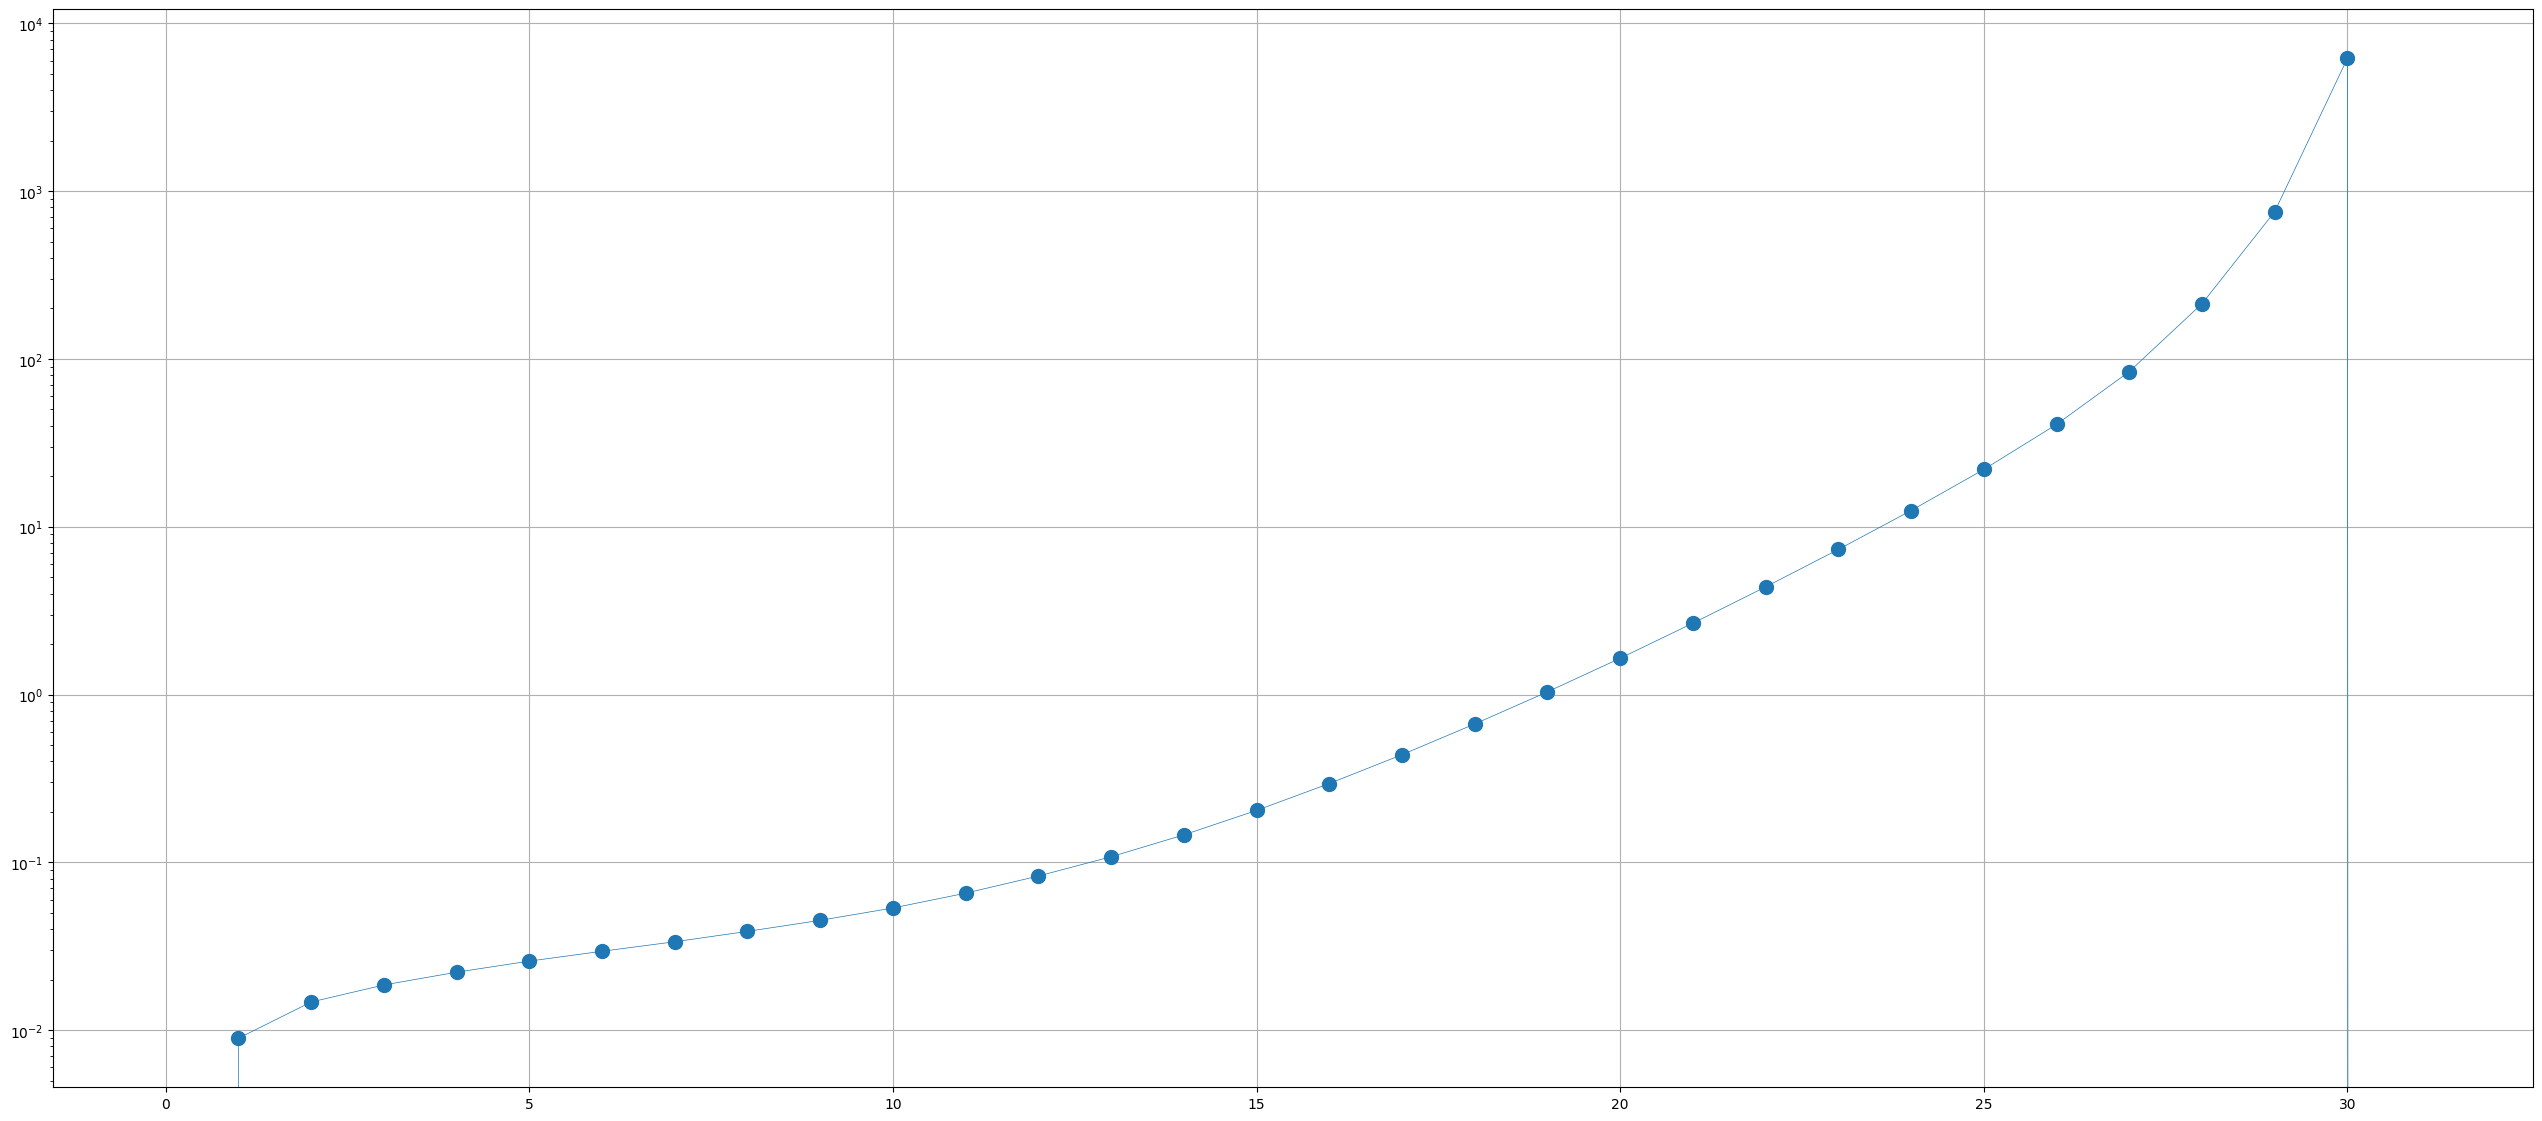

In [13]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(times,np.abs(mean_array_z[0,:]),yerr=std_array_z[0,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
_ = ax.set_yscale('log')
_ = ax.grid()

# Fit

In [95]:
cut = 7
fit_times = times[cut:-cut]
fit_data = mean_array_x[0,cut:-cut]
fit_data_std = std_array_x[0,cut:-cut]

guess_amp = -10**4
guess_mass = 0.4
guess_offset = 0.0


optimize_func = lambda x: x[0]*np.sinh(x[1]*(tvals-fit_times)) + x[2] - fit_data
est_amp_x, est_mass_x, est_offset_x = leastsq(optimize_func, [guess_amp, guess_mass, guess_offset])[0]

if verbose:
    print(f"Estimate amp  = {est_amp_x}")
    print(f"Estimate mass = {est_mass_x}")
    print(f"Estimate off  = {est_offset_x}")

Estimate amp  = -0.015763529981305733
Estimate mass = 0.32284193974864955
Estimate off  = -0.15100837339131673


In [96]:
fit_func = est_amp_x*np.sinh(est_mass_x*(tvals-fit_times)) + est_offset_x
fit_func

array([-25.37624582, -18.41630593, -13.3766943 ,  -9.72756966,
        -7.08528005,  -5.17202744,  -3.78666138,  -2.78353093,
        -2.05717164,  -1.53121747,  -1.15037206,  -0.87459509,
        -0.67489265,  -0.53026896,  -0.42551896,  -0.34962973,
        -0.29462262,  -0.25471444])

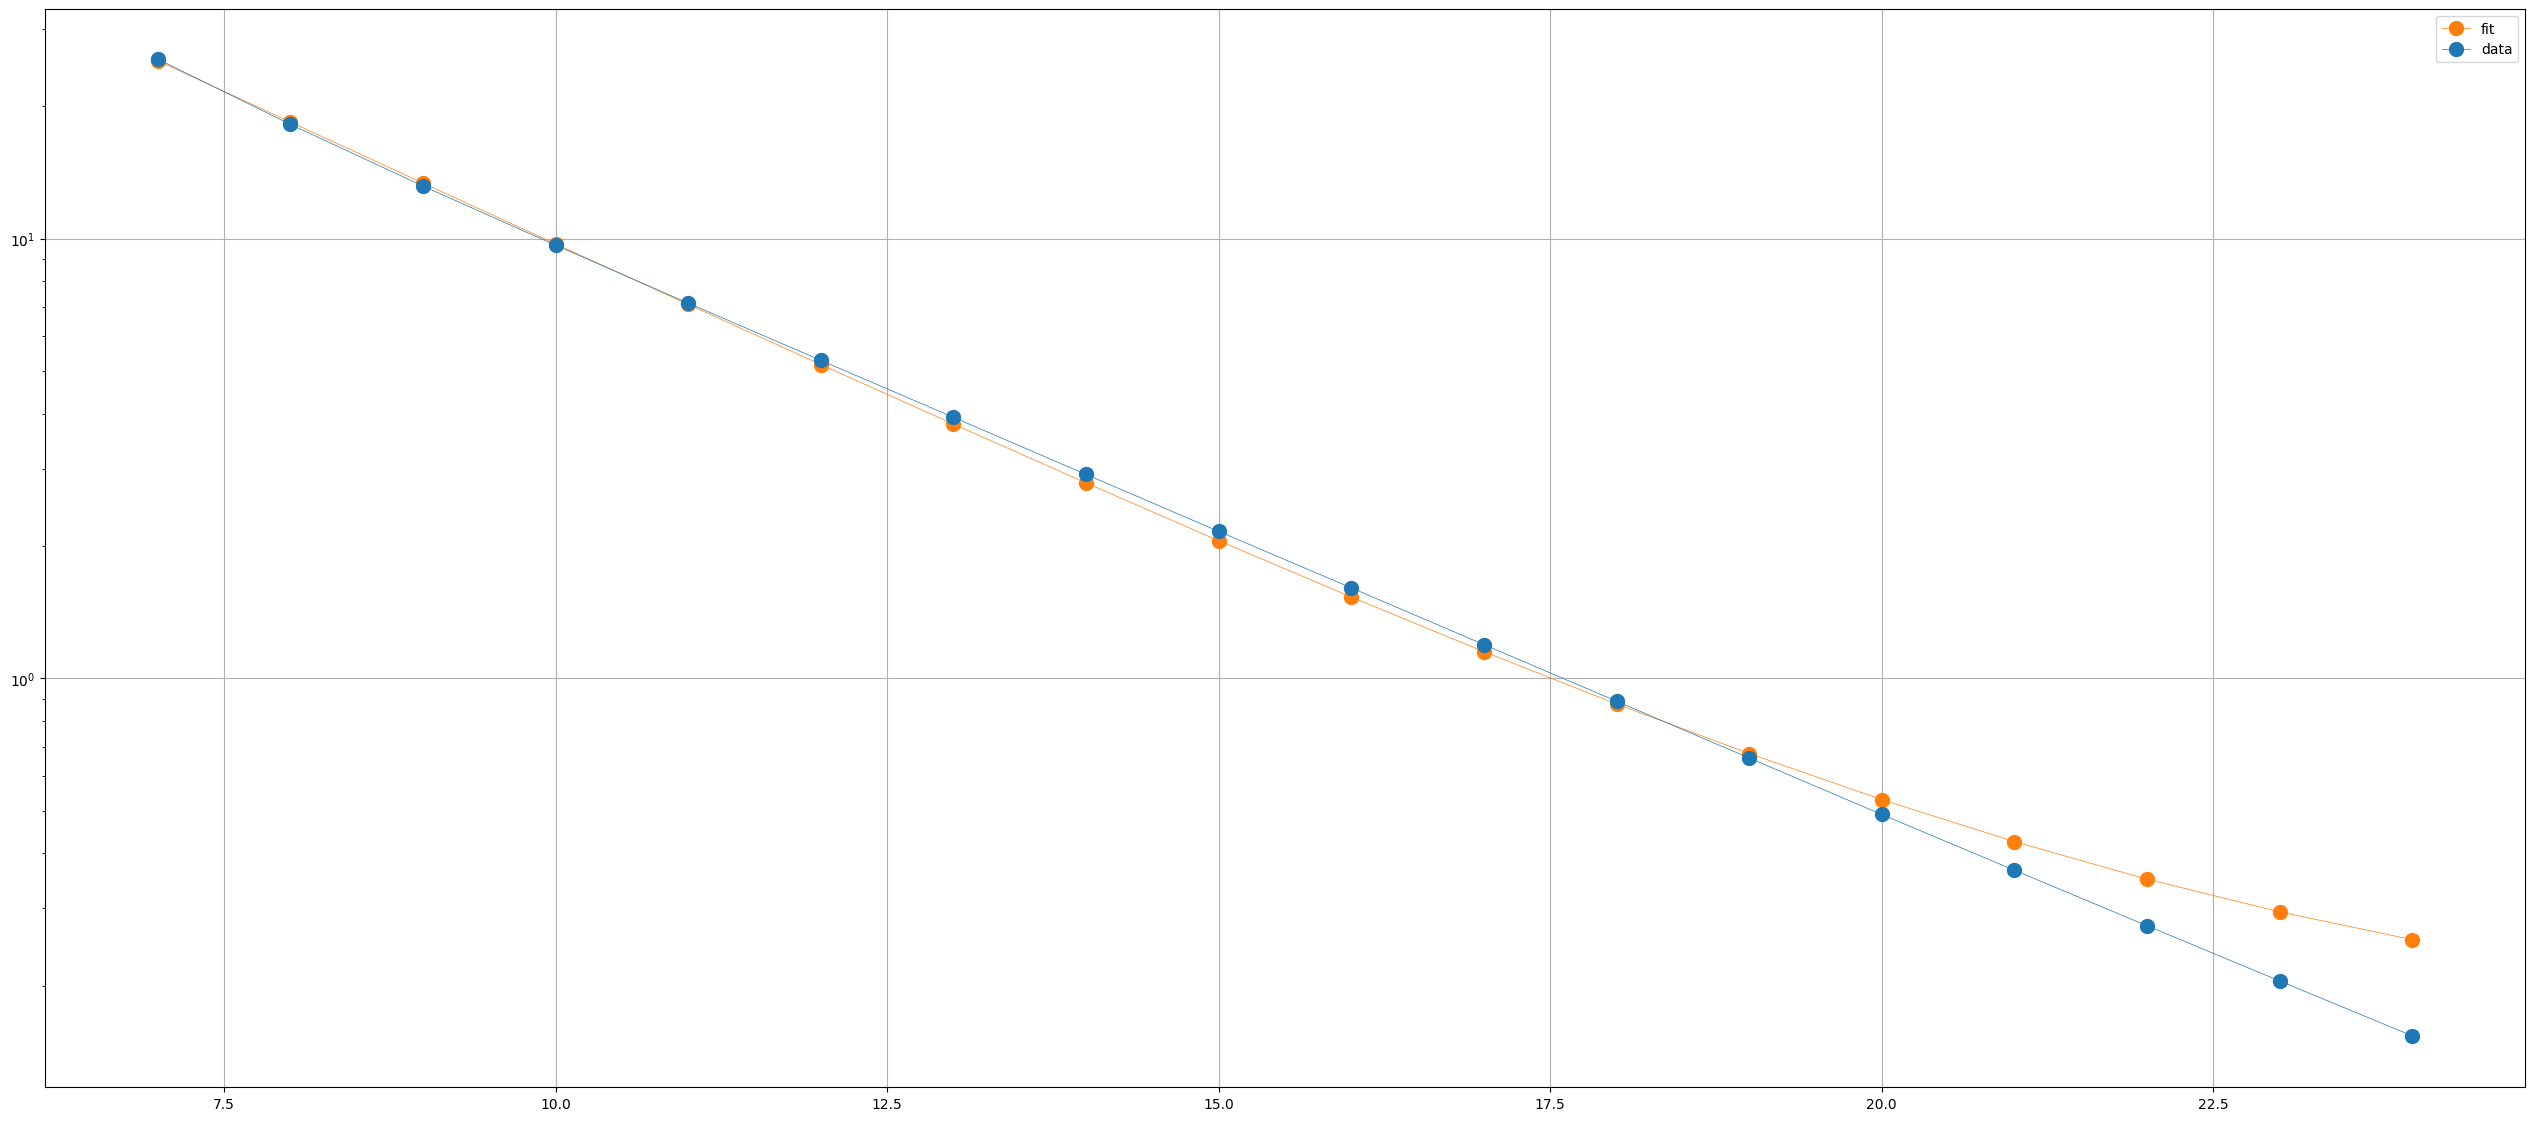

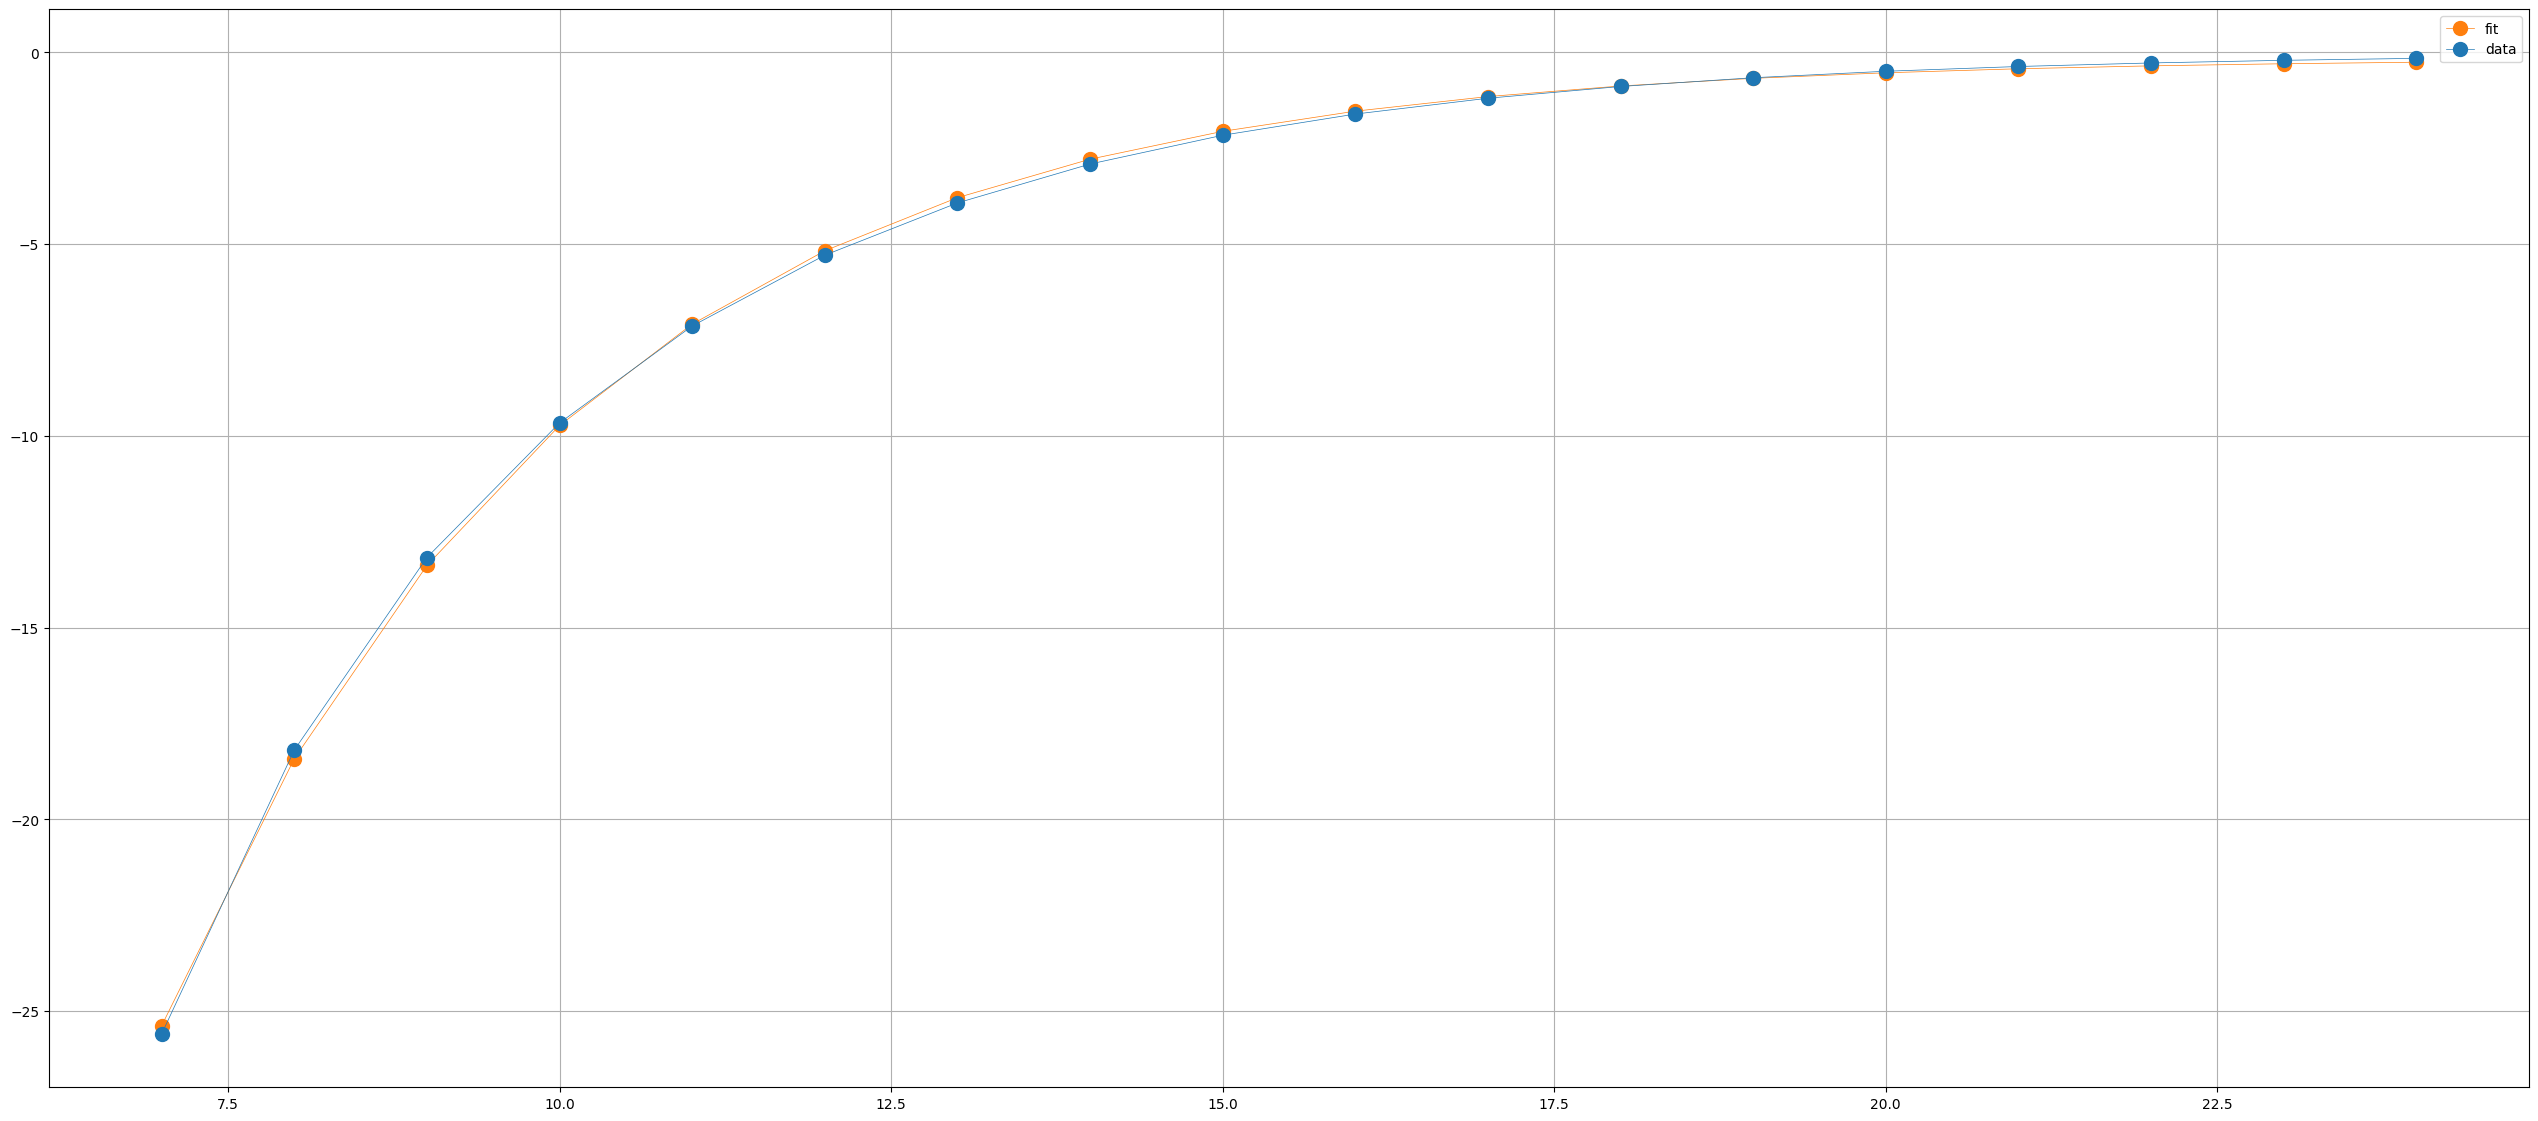

In [97]:
#times on x axis
#fit times

#fit
fit_result = est_amp_x*np.sinh(est_mass_x*(tvals-fit_times)) + est_offset_x

#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,np.abs(fit_data),yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,np.abs(fit_result),marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('log')

_ = ax.legend()
_ = ax.grid()

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,fit_data,yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,fit_result,marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('linear')

_ = ax.legend()
_ = ax.grid()

In [99]:
cut = 7
fit_times = times[cut:-cut]
fit_data = mean_array_z[0,cut:-cut]
fit_data_std = std_array_z[0,cut:-cut]

guess_amp = -10**4
guess_mass = 0.4
guess_offset = 0.0


optimize_func = lambda x: x[0]*np.sinh(x[1]*(fit_times)) + x[2] - fit_data
est_amp_z, est_mass_z, est_offset_z = leastsq(optimize_func, [guess_amp, guess_mass, guess_offset])[0]

if verbose:
    print(f"Estimate amp  = {est_amp_z}")
    print(f"Estimate mass = {est_mass_z}")
    print(f"Estimate off  = {est_offset_z}")

Estimate amp  = -8.76648845083092e-05
Estimate mass = 0.5229364680617208
Estimate off  = -0.07498704967316618


In [102]:
fit_func = est_amp_z*np.sinh(est_mass_z*(fit_times)) + est_offset_z
fit_func

array([ -0.07669026,  -0.07786155,  -0.07983699,  -0.0831692 ,
        -0.08879038,  -0.09827307,  -0.11427005,  -0.1412565 ,
        -0.18678194,  -0.26358215,  -0.39314212,  -0.61170642,
        -0.98041875,  -1.6024269 ,  -2.65173857,  -4.4219002 ,
        -7.40811708, -12.4457877 ])

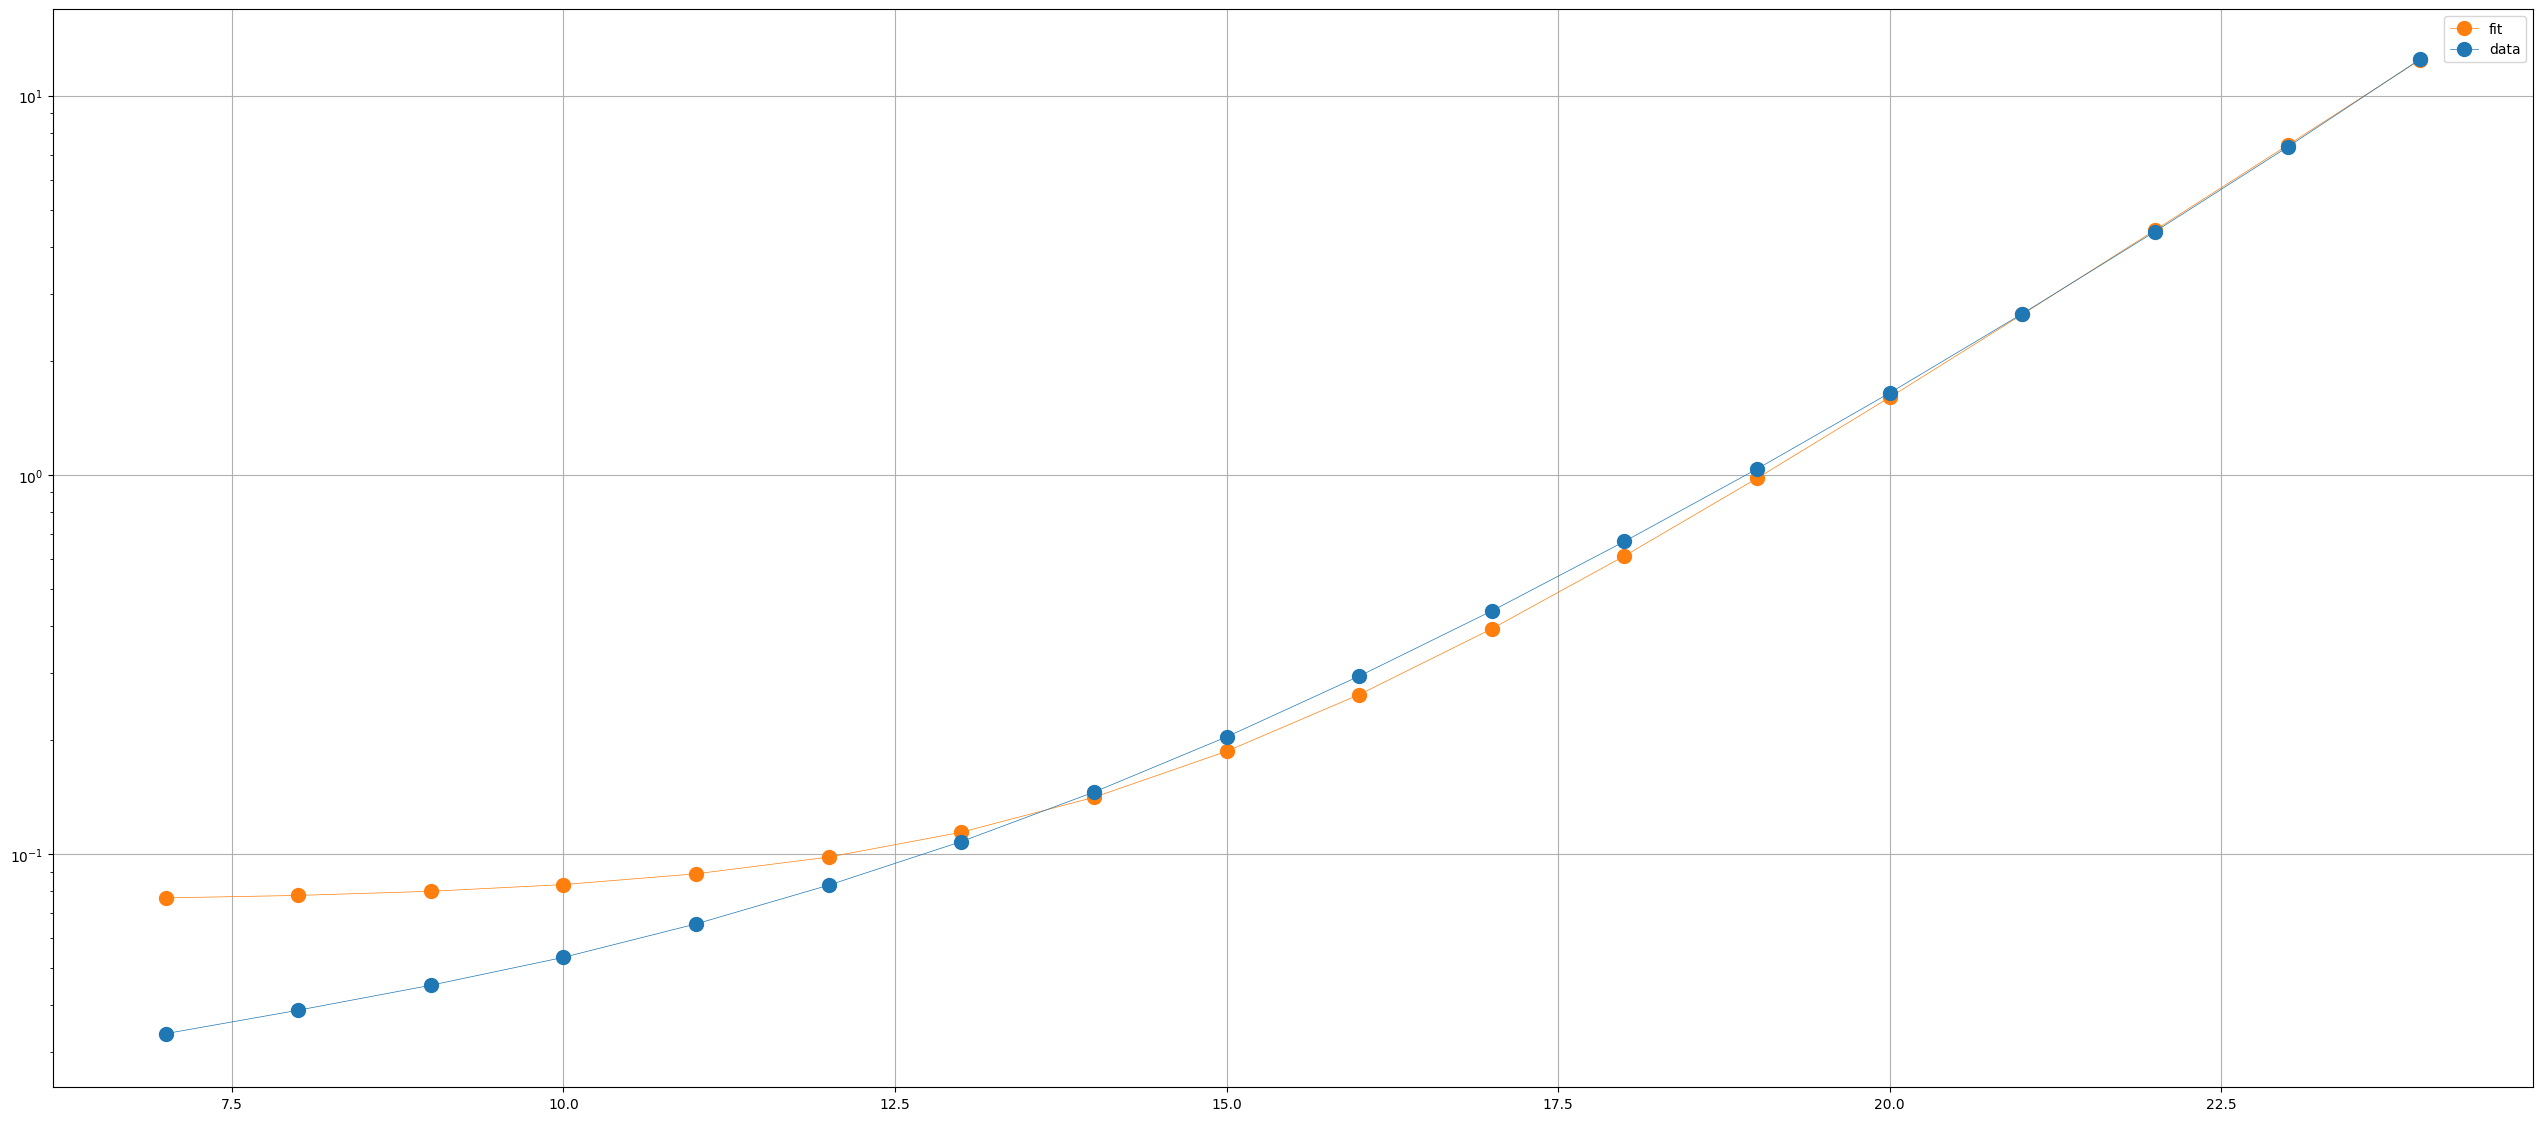

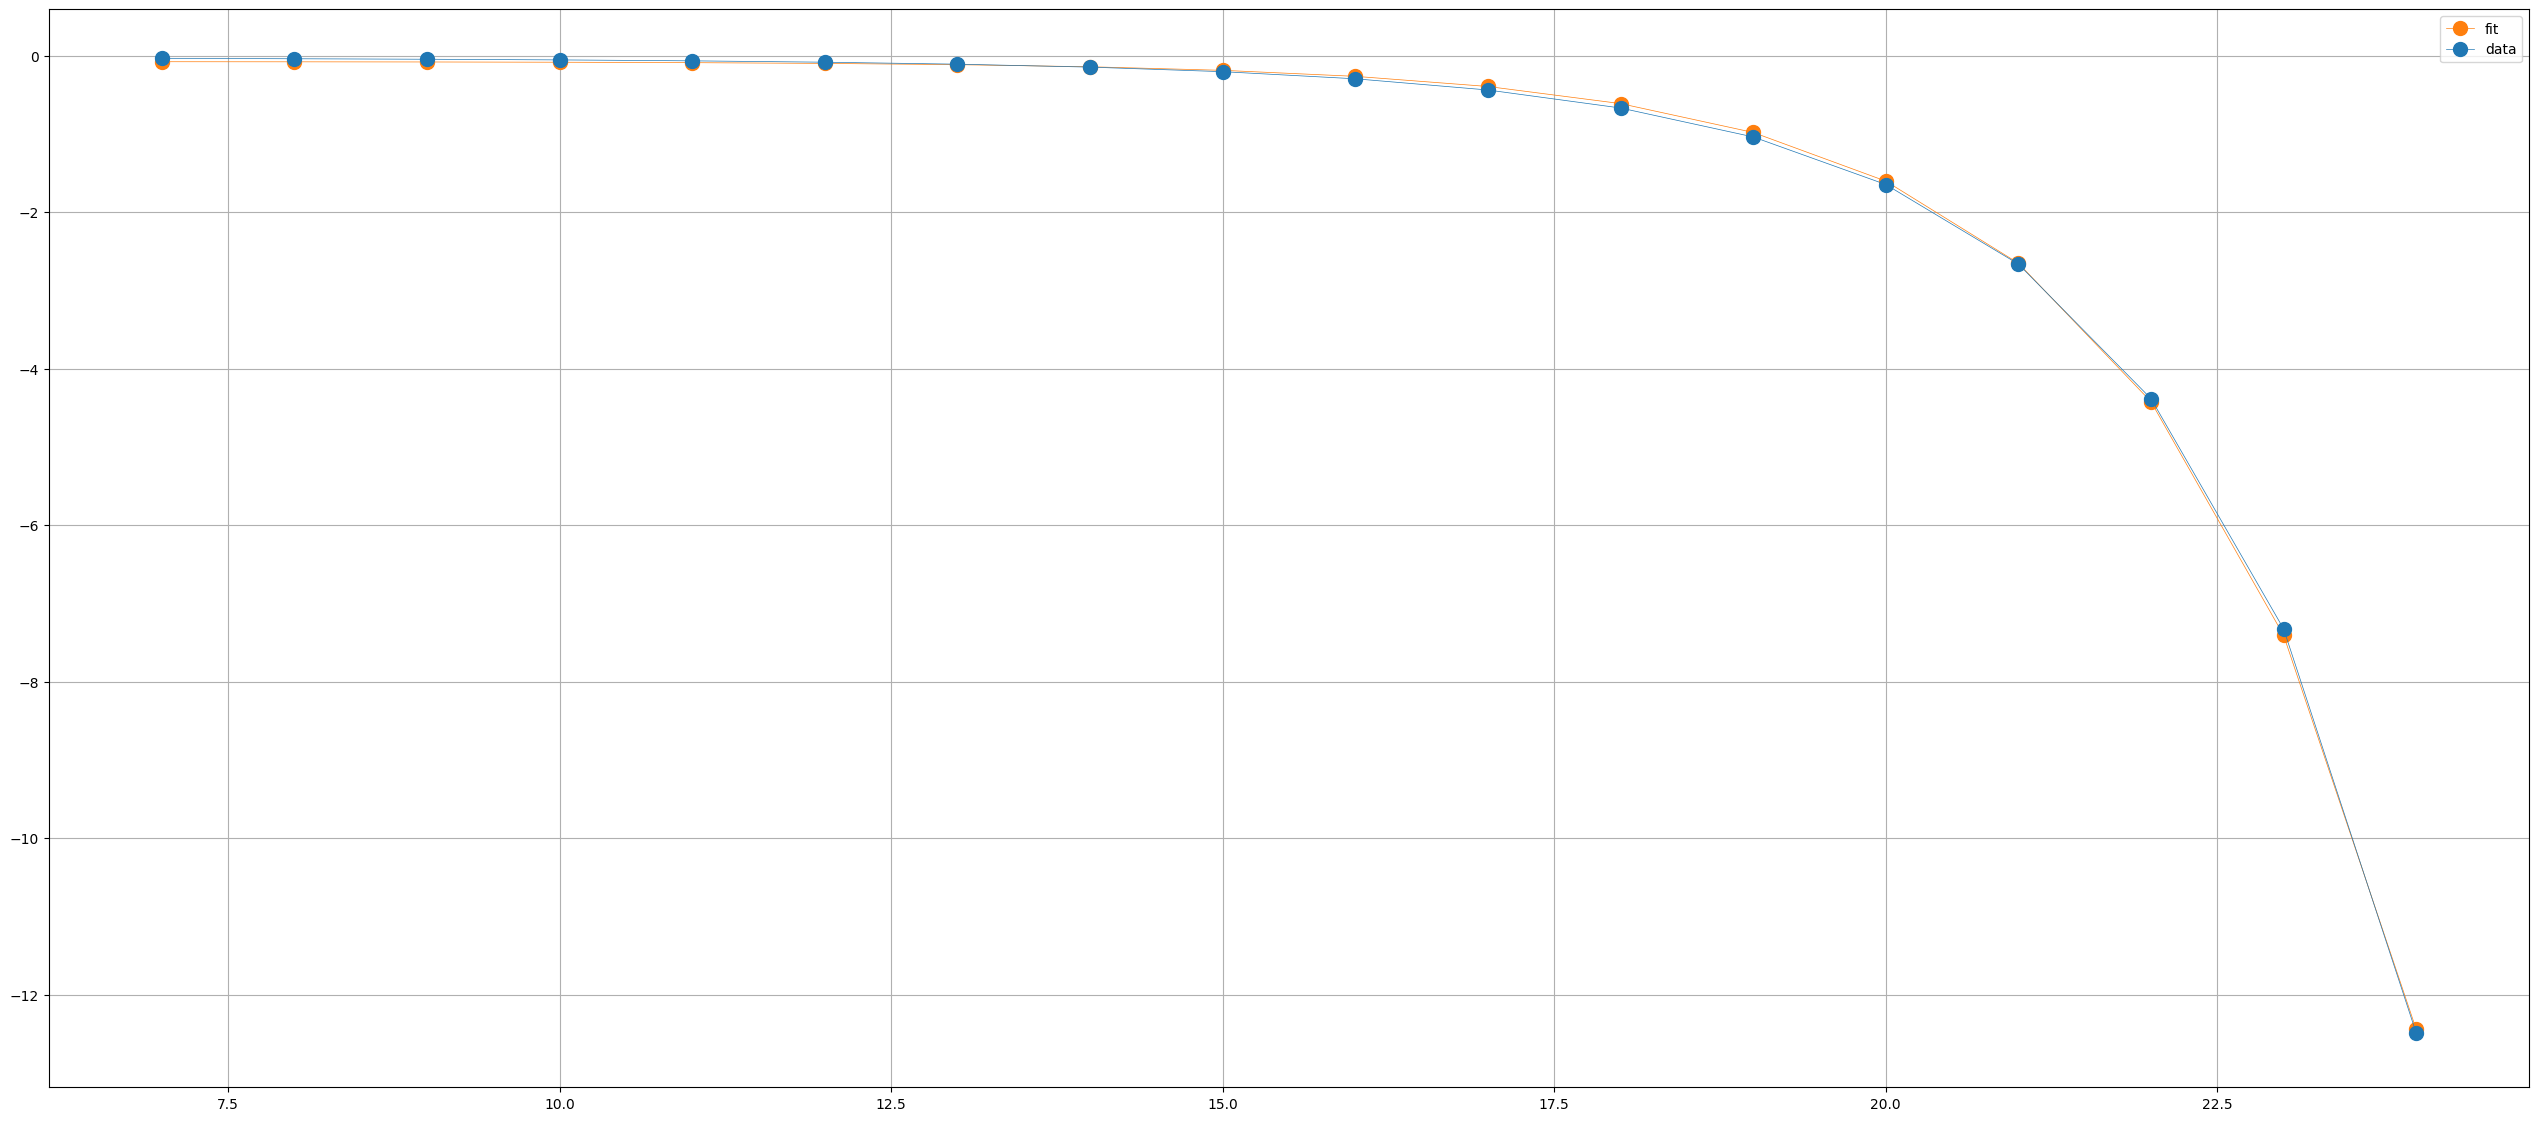

In [103]:
#times on x axis
#fit times

#fit
fit_result = est_amp_z*np.sinh(est_mass_z*(fit_times)) + est_offset_z

#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,np.abs(fit_data),yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,np.abs(fit_result),marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('log')

_ = ax.legend()
_ = ax.grid()

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,fit_data,yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,fit_result,marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('linear')

_ = ax.legend()
_ = ax.grid()

In [104]:
(est_mass_x+est_mass_z)/2

0.42288920390518514

## using curvefit

In [132]:
cut = 7
fit_times = times[cut:-cut]
fit_data = mean_array_x[0,cut:-cut]
fit_data_std = std_array_x[0,cut:-cut]

def my_opt_func(t,amp,mass,off):
    return amp*np.sinh(mass*(tvals-fit_times)) + off

p0 = [-10**4,0.4,0.0]

popt,pcov = curve_fit(my_opt_func, fit_times, fit_data, p0=p0)
perr = np.sqrt(np.diag(pcov))

if verbose:
    print(f"amp  = {popt[0]} +- {perr[0]}")
    print(f"mass = {popt[1]} +- {perr[1]}")
    print(f"off  = {popt[2]} +- {perr[2]}")

amp  = -0.015763529981305733 +- 0.0012472590340440932
mass = 0.32284193974864955 +- 0.0032023730170186292
off  = -0.15100837339131673 +- 0.05188608550635664


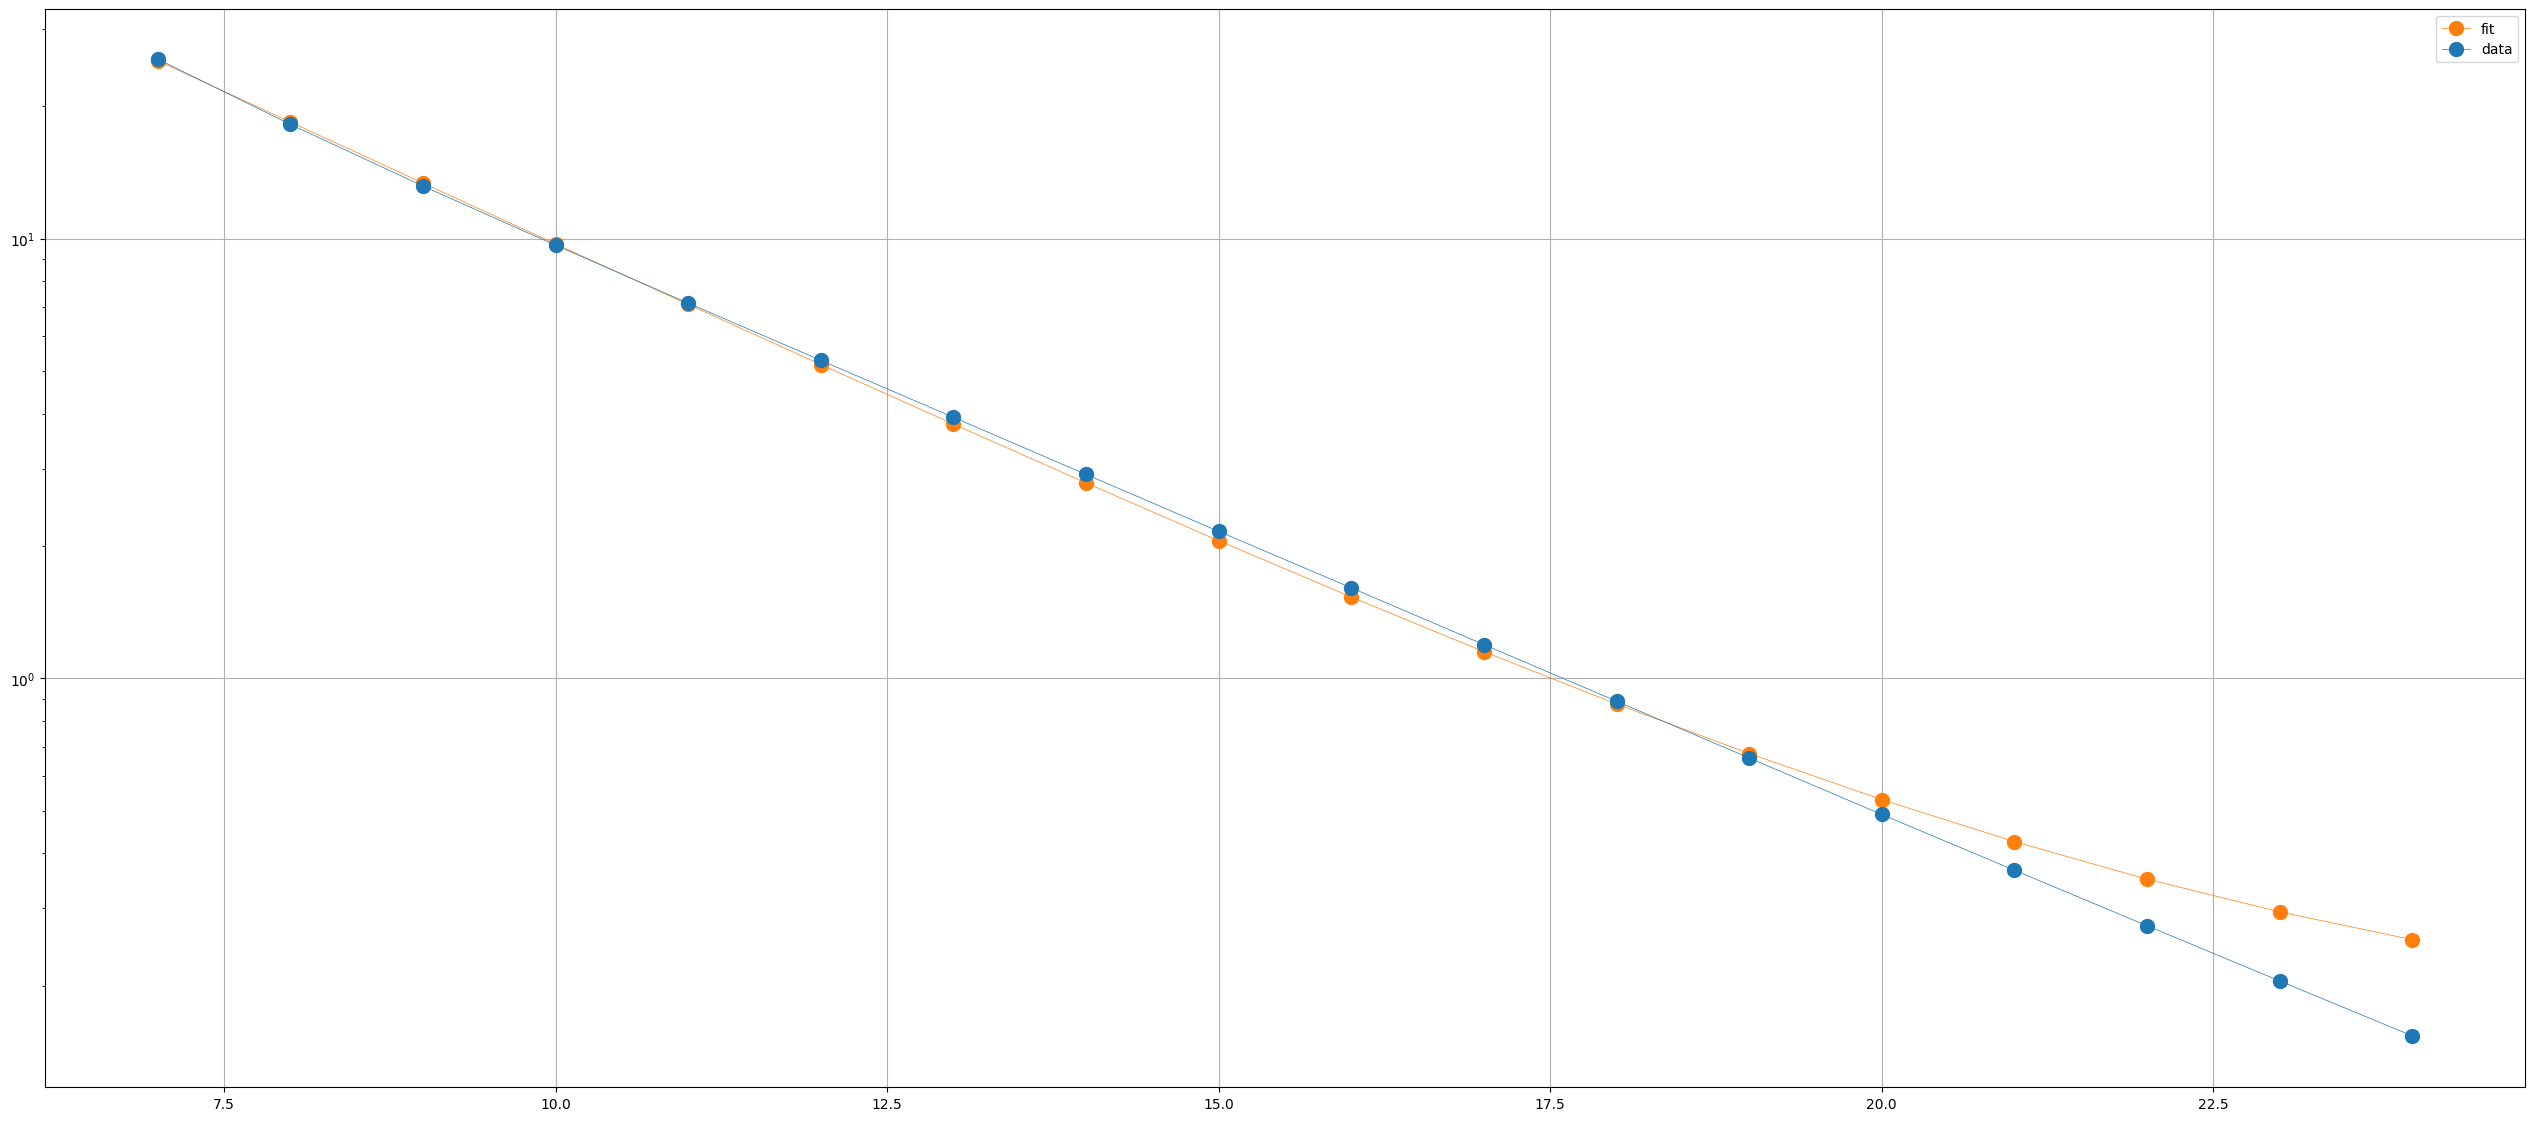

In [133]:
#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,np.abs(fit_data),yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,np.abs(my_opt_func(fit_times,popt[0],popt[1],popt[2])),marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('log')

_ = ax.legend()
_ = ax.grid()

In [134]:
cut = 7
fit_times = times[cut:-cut]
fit_data = mean_array_z[0,cut:-cut]
fit_data_std = std_array_z[0,cut:-cut]

def my_opt_func(t,amp,mass,off):
    return amp*np.sinh(mass*(fit_times)) + off

p0 = [-10**4,0.4,0.0]

popt,pcov = curve_fit(my_opt_func, fit_times, fit_data, p0=p0)
perr = np.sqrt(np.diag(pcov))

if verbose:
    print(f"amp  = {popt[0]} +- {perr[0]}")
    print(f"mass = {popt[1]} +- {perr[1]}")
    print(f"off  = {popt[2]} +- {perr[2]}")

amp  = -8.76649158580069e-05 +- 7.593419477420555e-06
mass = 0.5229364530391903 +- 0.0036504685552529808
off  = -0.07498700866387582 +- 0.013652510134433075


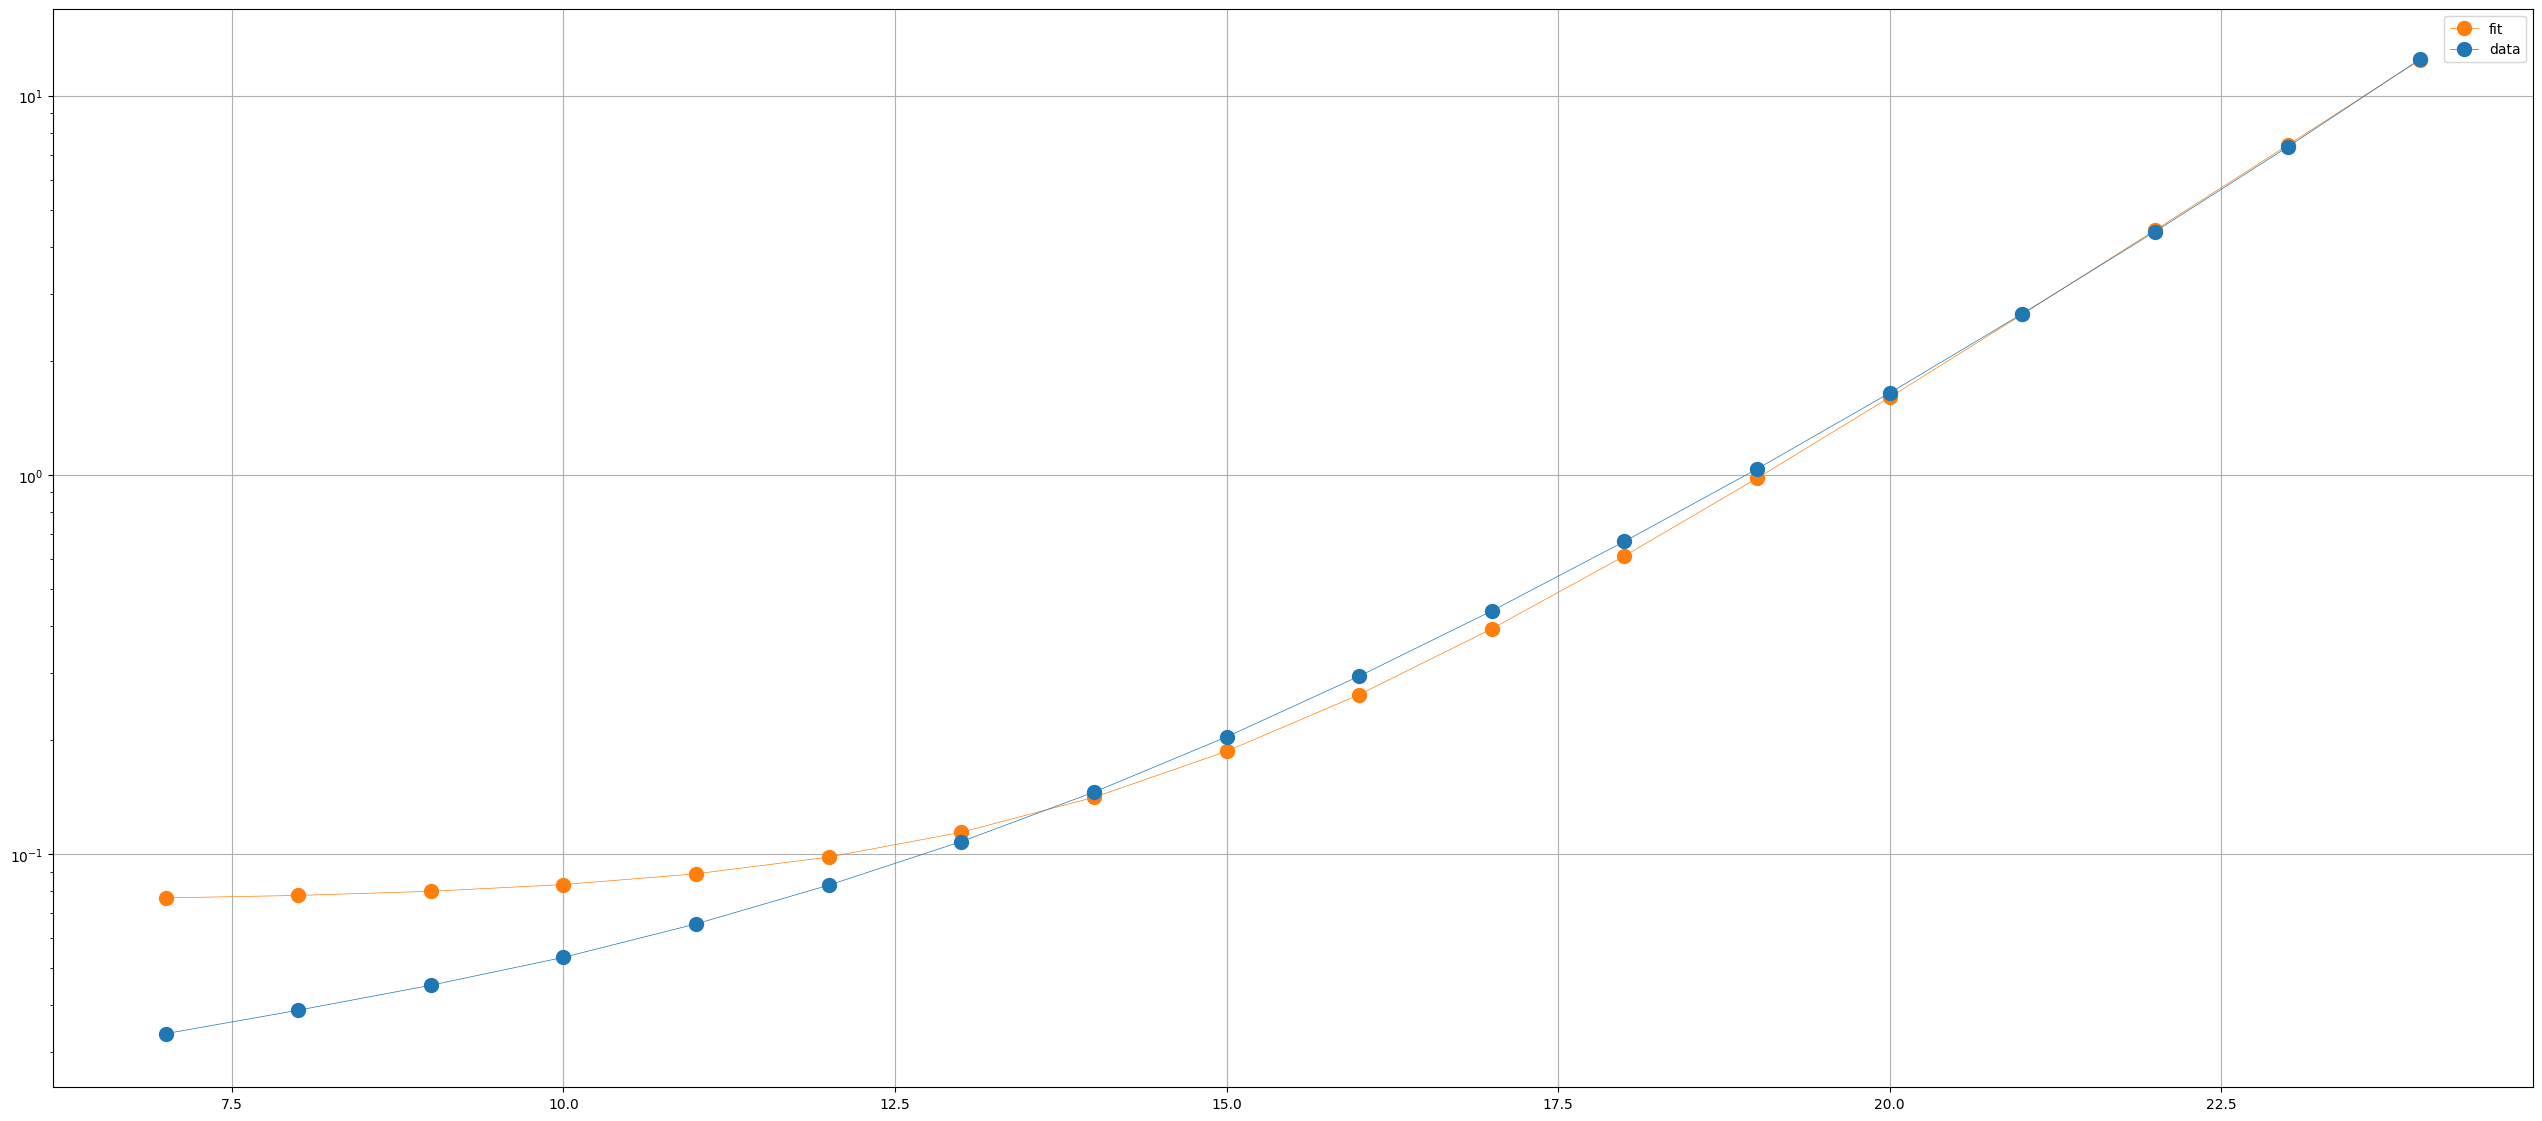

In [135]:
#create figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax.errorbar(fit_times,np.abs(fit_data),yerr=fit_data_std,marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='data')
_ = ax.plot(fit_times,np.abs(my_opt_func(fit_times,popt[0],popt[1],popt[2])),marker='o',linestyle='solid',markersize=10,linewidth=0.5,label='fit')
_ = ax.set_yscale('log')

_ = ax.legend()
_ = ax.grid()